# Searching for an optimal number of topics for the BTM

In [1]:
# Import libraries
import pandas as pd
import re
from tqdm import tqdm
import bitermplus as btm
from statistics import mean
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import dropbox
import io

# Connect to dropbox for raw data DO NOT COMMIT TOKEN
access_token = 'XXXX'
dbx = dropbox.Dropbox(access_token)

pd.options.mode.chained_assignment = None

## Prepare data files

In [3]:
# Load processed data
md, response = dbx.files_download("/ClassifyingESTC/intermediate_output/estc_btm_prepped.csv")
filtered_data = pd.read_csv(io.BytesIO(response.content), encoding = "ISO-8859-1")

# prepare BTM files
texts = filtered_data["clean_title"].to_list()
X, vocabulary, vocab_dict = btm.get_words_freqs(filtered_data["clean_title"]) # Stopwords already removed in 00
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
biterms = btm.get_biterms(docs_vec)

## Wide search for a good model

In [4]:
# Metrics for selecting best model
coherance = []
perplexity = []
entropy = []

# Loop through a range of models (from 5 to 50 topics)
for k in tqdm(range(5, 55, 5)):

    model = btm.BTM(
        n_dw = X, # Documents vs words frequency matrix
        vocabulary = vocabulary, # List of all words
        seed = 931, # Random state seed, set for repeatability
        T = k, # Number of topics
        alpha = 50/k, # Symmetric dirichlet prior probability of a topic P(z) (literature default)
        beta = 0.01 # Symmetric dirichlet prior probability of a word given the topic P(w|z) (literature default)
    )
    model.fit(biterms, iterations=100, verbose=False) # limit iterations for speed (only need a rough fit for search)
    
    # Update metrics
    coherance.append(mean(model.coherence_))
    perplexity.append(model.perplexity_)
    entropy.append(btm.entropy(model.matrix_topics_words_))

100%|████████████████████████████████████████| 10/10 [1:26:03<00:00, 516.36s/it]


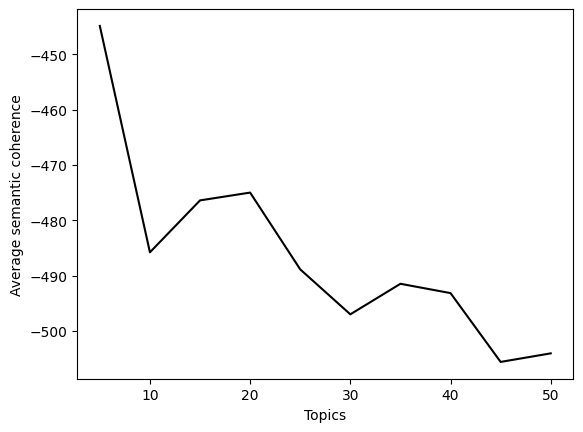

In [5]:
# plot coherance
plt.plot(range(5, 55, 5), coherance, color='black')
plt.ylabel("Average semantic coherence")
plt.xlabel("Topics")
plt.locator_params(axis="both", integer=True, tight=True)
plt.show()

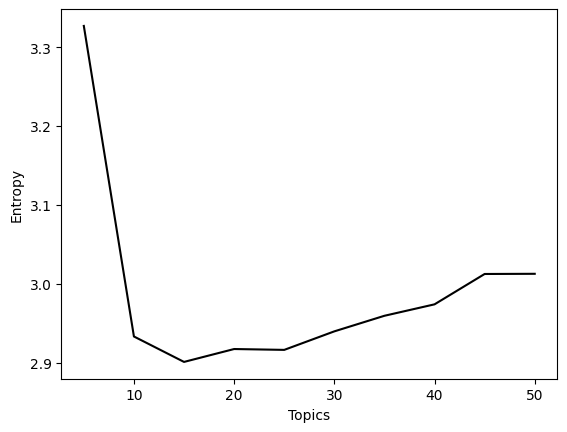

In [6]:
# plot entropy
plt.plot(range(5, 55, 5), entropy, color='black')
plt.ylabel("Entropy")
plt.xlabel("Topics")
plt.locator_params(axis="both", integer=True, tight=True)
plt.show()

Seems to suggest the optimal number of topics is around 10-25.